In [4]:
#import all relevant packages
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.utils import resample

import matplotlib.pyplot as plt

import os
from pathlib import Path
from subprocess import call

from IPython.display import Image

# Functions 

In [5]:
#Input:a list of ints or floats
#Output: return the minimum from the list
def FindMin(counts):
    minimum = counts[0]
    index = 0
    
    for i,val in enumerate(counts):
        if val < minimum:
            minimum = val
            index = i
            
    return minimum, index


#Input: the target variable as a string and the avyData frame
#Output: two list of values corresponding to the features (independent var) and targets (dependent var)
def Set_Features_Targets(target,avyData):
    if target == persistentLabel:
        Y = avyData.o_PersistentSlab_Likelihood.values
    elif target == windLabel:
        Y = avyData.o_WindSlab_Likelihood.values

    X = avyData.iloc[:, wForecastindex:aForecastindex].values

    return X,Y


#Input: the index of the category with smallest counts & a list of dataframes corresponding to each category of
#the target variable
#Ouput: a single data frame with balanced categories
def Balance_Target_Categories(index,catDataFrames):
    for i in range(0, 4):
        if i != index:
            catDataFrames[i] = resample(catDataFrames[i], replace=False, n_samples=minimum, random_state=99)
    avyData = pd.concat([catDataFrames[0], catDataFrames[1], catDataFrames[2], catDataFrames[3], catDataFrames[4]])
    print('Revised data shape:', avyData.shape)
    return avyData


#Input: the target variable string and the raw data frame
#Output: a list of data frames corresponding to each category of the target variable and
# the counts for each category in order from unlikely to certain
def Separate_Target_Categories(target,rawData):

    catDataFrames = np.empty(5, dtype=object)
    if target == 'o_PersistentSlab_Likelihood':

        # Remove any rows missing data for Persistent Slab likelihood column. Determine category counts
        rawData = rawData[rawData.o_PersistentSlab_Likelihood != "no-data"];
        categoryCounts = rawData.o_PersistentSlab_Likelihood.value_counts()
        print("Category counts:\n", categoryCounts)

        # Separate out the categories into separate dataframes to balance
        catDataFrames[0] = rawData[rawData.o_PersistentSlab_Likelihood == '0-unlikely']
        catDataFrames[1] = rawData[rawData.o_PersistentSlab_Likelihood == '1-possible']
        catDataFrames[2] = rawData[rawData.o_PersistentSlab_Likelihood == '2-likely']
        catDataFrames[3] = rawData[rawData.o_PersistentSlab_Likelihood == '3-very likely']
        catDataFrames[4] = rawData[rawData.o_PersistentSlab_Likelihood == '4-certain']

    elif target == 'o_WindSlab_Likelihood':

        # Remove any rows missing data for wind Slab likelihood column.
        rawData = rawData[rawData.o_WindSlab_Likelihood != "no-data"];
        categoryCounts = rawData.o_WindSlab_Likelihood.value_counts()
        print("Category counts:\n", categoryCounts)
        print("\n")

        # Separate out the categories into separate dataframes to balance
        catDataFrames[0] = rawData[rawData.o_WindSlab_Likelihood == '0-unlikely']
        catDataFrames[1] = rawData[rawData.o_WindSlab_Likelihood == '1-possible']
        catDataFrames[2] = rawData[rawData.o_WindSlab_Likelihood == '2-likely']
        catDataFrames[3] = rawData[rawData.o_WindSlab_Likelihood == '3-very likely']
        catDataFrames[4] = rawData[rawData.o_WindSlab_Likelihood == '4-certain']

    return catDataFrames,categoryCounts


#Input: the target variable string,the model object, feature variable's labels, and the categories of the target var
#Output: saves the dot file as a png and returns the Image
def Display_Save_Tree(target, rfModel,featureLabels,targetCategories):

    tree = rfModel.estimators_[0]
    export_graphviz(tree,
                    out_file= target[2:]+'_tree.dot',
                    feature_names = featureLabels,
                    class_names = targetCategories,
                    rounded = True, proportion = False,
                    precision = 2, filled = True,leaves_parallel = True)
    
     # Save tree dot file as png
    call(['dot', '-Tpng', target[2:]+'_tree.dot', '-o',target[2:]+'_tree.png', '-Gdpi=500'])
    return Image(filename= target[2:]+'_tree.png')


#Input: an array of importances corresponding to the features in order given in the dataframe and the array of
#the feature labels
#Output:a sorted array of pairs, each feature with its importance
def Sort_Display_Feature_Importance(importances,featureLabels):
    featureANDimportance = np.empty(len(importances), dtype=object)

    for i in range(0, len(importances)):
        featureANDimportance[i] = (featureLabels[i], importances[i])

    # Sort the feature importances by most important first
    featureANDimportance = sorted(featureANDimportance, key=lambda x: x[1], reverse=True)

    print("Feature Importance Rank:")
    for i in range(len(featureANDimportance)):
        print("%s :  %s" % (featureANDimportance[i][0], featureANDimportance[i][1]))

    return featureANDimportance

# Reading in the Data

In [6]:
#Combined Forecast data file path
directory = Path(os.getcwd())
fileName = "RawData.csv"
filePath = directory / fileName

#Read in a csv file into a dataframe and show columns
rawData = pd.read_csv(filePath,low_memory=False)

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

print('Raw data shape:', rawData.shape)

Raw data shape: (163674, 343)


In [7]:
#Convert the values in Date column to the Date type in pandas, sort dataframe based on date and location
rawData["Date"] = pd.to_datetime(rawData["Date"])
rawData = rawData.sort_values(["Lat", "Date"], ascending = (True,True))
rawData.head()

,Date,Lat,Lon,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,n_f_APCPsurface6HourForecast,n_f_10mWindSpeed6HourForecast,n_f_APCPsurface7HourForecast,n_f_10mWindSpeed7HourForecast,n_f_APCPsurface8HourForecast,n_f_10mWindSpeed8HourForecast,n_f_APCPsurface9HourForecast,n_f_10mWindSpeed9HourForecast,n_f_APCPsurface10HourForecast,n_f_10mWindSpeed10HourForecast,n_f_APCPsurface11HourForecast,n_f_10mWindSpeed11HourForecast,n_f_APCPsurface12HourForecast,n_f_10mWindSpeed12HourForecast,n_f_APCPsurface13HourForecast,n_f_10mWindSpeed13HourForecast,n_f_APCPsurface14HourForecast,n_f_10mWindSpeed14HourForecast,n_f_APCPsurface15HourForecast,n_f_10mWindSpeed15HourForecast,n_f_APCPsurface16HourForecast,n_f_10mWindSpeed16HourForecast,n_f_APCPsurface17HourForecast,n_f_10mWindSpeed17HourForecast,n_f_APCPsurface18HourForecast,n_f_10mWindSpeed18HourForecast,n_f_APCPsurface19HourForecast,n_f_10mWindSpeed19HourForecast,n_f_APCPsurface20HourForecast,n_f_10mWindSpeed20HourForecast,n_f_APCPsurface21HourForecast,n_f_10mWindSpeed21HourForecast,n_f_APCPsurface22HourForecast,n_f_10mWindSpeed22HourForecast,n_f_APCPsurface23HourForecast,n_f_10mWindSpeed23HourForecast,n_f_tempMaxF,n_f_10mWindSpeedMax,n_r_snowDepthIn,n_f_tempMinF,n_f_tempAveF,n_f_10mWindSpeed,n_f_APCPsurface,n_r_precipIncrementSnowIn,n_r_Prev3daySnowAccumulation,n_r_Prev7daySnowAccumulation,n_r_Prev3dayMaxTemp,n_r_Prev3DayMax10mWind,n_r_Prev3dayMinTemp,n_r_Prev7dayMaxTemp,n_r_Prev7DayMax10mWind,n_r_Prev7dayMinTemp,n_r_Prev1dayMaxTemp,n_r_Prev1DayMax10mWind,n_r_Prev1dayMinTemp,n_r_Prev1DayPrecip,c_r_Prev3DayFreezeThawLikeliness,c_r_Prev7DayFreezeThawLikeliness,n_f_Next24HourChangeInTempFromPrev3DayMax,n_f_Next24HoursChangeInTempFromPrev1DayMax,c_f_LongTermColdTemps,n_r_Prev24HoursPrecipAsRainTotalIn,n_r_SNOWDAS_SnowDepth_mm,n_r_SNOWDAS_SWE_mm,n_r_SNOWDAS_SnowmeltRunoff_micromm,n_r_SNOWDAS_Sublimation_micromm,n_r_SNOWDAS_SolidPrecip_kgpersquarem,n_r_SNOWDAS_LiquidPrecip_kgpersquarem,n_r_SNOWDAS_SnowpackAveTemp_k,n_r_snowDepthIn1InPast,n_r_precipIncrementSnowIn1InPast,n_r_Prev3daySnowAccumulation1InPast,n_r_Prev7daySnowAccumulation1InPast,n_r_Prev3dayMaxTemp1InPast,n_r_Prev3DayMax10mWind1InPast,n_r_Prev3dayMinTemp1InPast,n_r_Prev7dayMaxTemp1InPast,n_r_Prev7DayMax10mWind1InPast,n_r_Prev7dayMinTemp1InPast,n_r_Prev1dayMaxTemp1InPast,n_r_Prev1DayMax10mWind1InPast,n_r_Prev1dayMinTemp1InPast,n_r_Prev1DayPrecip1InPast,c_r_Prev3DayFreezeThawLikeliness1InPast,c_r_Prev7DayFreezeThawLikeliness1InPast,n_r_Prev24HoursPrecipAsRainTotalIn1InPast,n_r_SNOWDAS_SnowDepth_mm1InPast,n_r_SNOWDAS_SWE_mm1InPast,n_r_SNOWDAS_SnowmeltRunoff_micromm1InPast,n_r_SNOWDAS_Sublimation_micromm1InPast,n_r_SNOWDAS_SolidPrecip_kgpersquarem1InPast,n_r_SNOWDAS_LiquidPrecip_kgpersquarem1InPast,n_r_SNOWDAS_SnowpackAveTemp_k1InPast,n_r_snowDepthIn2InPast,n_r_precipIncrementSnowIn2InPast,n_r_Prev3daySnowAccumulation2InPast,n_r_Prev7daySnowAccumulation2InPast,n_r_Prev3dayMaxTemp2InPast,n_r_Prev3DayMax10mWind2InPast,n_r_Prev3dayMinTemp2InPast,n_r_Prev7dayMaxTemp2InPast,n_r_Prev7DayMax10mWind2InPast,n_r_Prev7dayMinTemp2InPast,n_r_Prev1dayMaxTemp2InPast,n_r_Prev1DayMax10mWind2InPast,n_r_Prev1dayMinTemp2InPast,n_r_Prev1DayPrecip2InPast,c_r_Prev3DayFreezeThawLikeliness2InPast,c_r_Prev7DayFreezeThawLikeliness2InPast,n_r_Prev24HoursPrecipAsRainTotalIn2InPast,n_r_SNOWDAS_SnowDepth_mm2InPast,n_r_SNOWDAS_SWE_mm2InPast,n_r_SNOWDAS_SnowmeltRunoff_micromm2InPast,n_r_SNOWDAS_Sublimation_micromm2InPast,n_r_SNOWDAS_SolidPrecip_kgpersquarem2InPast,n_r_SNOWDAS_LiquidPrecip_kgpersquarem2InPast,n_r_SNOWDAS_SnowpackAveTemp_k2InPast,n_r_snowDepthIn3InPast,n_r_precipIncrementSnowIn3InPast,n_r_Prev3daySnowAccumulation3InPast,n_r_Prev7daySnowAccumulation3InPast,n_r_Prev3dayMaxTemp3InPast,n_r_Prev3DayMax10mWind3InPast,n_r_Pr

In [8]:
#Replace any weather cell that had missing data with NaN. Drop all of the rows with NaN
rawData.replace(-9999.0,np.nan)
rawData.dropna()

numCols = len(rawData.columns)
labels = rawData.columns

aForecastindex = rawData.columns.get_loc('Region') #Start of avalanche forecast
wForecastindex = rawData.columns.get_loc('n_f_APCPsurface1HourForecast') #Start of weather forecast
print("Total number of columns: %s\n Index of weather forecast: %s\n Index of avalanche forecast: %s" %(numCols,wForecastindex,aForecastindex))

Total number of columns: 343
 Index of weather forecast: 3
 Index of avalanche forecast: 324


In [9]:
#Look at the data types for each column -
rawData.dtypes

Date                                             datetime64[ns]
Lat                                                     float64
Lon                                                     float64
n_f_APCPsurface1HourForecast                            float64
n_f_10mWindSpeed1HourForecast                           float64
n_f_APCPsurface2HourForecast                            float64
n_f_10mWindSpeed2HourForecast                           float64
n_f_APCPsurface3HourForecast                            float64
n_f_10mWindSpeed3HourForecast                           float64
n_f_APCPsurface4HourForecast                            float64
n_f_10mWindSpeed4HourForecast                           float64
n_f_APCPsurface5HourForecast                            float64
n_f_10mWindSpeed5HourForecast                           float64
n_f_APCPsurface6HourForecast                            float64
n_f_10mWindSpeed6HourForecast                           float64
n_f_APCPsurface7HourForecast            

# Balance data for each category of target


In [10]:
persistentLabel = "o_PersistentSlab_Likelihood"
windLabel = "o_WindSlab_Likelihood"
target = windLabel

catData,catCounts =Separate_Target_Categories(target,rawData)
minimum,index = FindMin(catCounts)
avyData = Balance_Target_Categories(index,catData)



Category counts:
 1-possible       46598
2-likely         36650
0-unlikely        8413
3-very likely     6155
4-certain          205
Name: o_WindSlab_Likelihood, dtype: int64


Revised data shape: (1025, 343)


# Designate input and out --> Create train and test sets--> Build Model

In [11]:
#Capture the category names which are the same for every avalanche problem
targetCategories = avyData.o_PersistentSlab_Likelihood.unique()
featureLabels = list(avyData.columns[wForecastindex:aForecastindex])

#Set feautres and target arrays 
X,Y = Set_Features_Targets(target,avyData)

#Split data into a training and test set
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size = .3,random_state = 99)

maxTreeDepth = 10
minNumLeaves = 5
numTrees = 10

rfModel = RandomForestClassifier(n_estimators= numTrees,max_depth = maxTreeDepth, min_samples_leaf = minNumLeaves )
rfModel = rfModel.fit(X, Y)

# Make Prediction with Model on test set,

In [12]:
Ypred = rfModel.predict(Xtest)

print(classification_report(Ytest,Ypred))
print(confusion_matrix(Ytest,Ypred))
print(accuracy_score(Ytest, Ypred))

               precision    recall  f1-score   support

   0-unlikely       0.87      0.95      0.90        55
   1-possible       0.84      0.84      0.84        61
     2-likely       0.94      0.78      0.85        60
3-very likely       0.91      0.97      0.94        66
    4-certain       0.97      0.98      0.98        66

     accuracy                           0.91       308
    macro avg       0.91      0.90      0.90       308
 weighted avg       0.91      0.91      0.90       308

[[52  2  1  0  0]
 [ 7 51  2  1  0]
 [ 1  6 47  5  1]
 [ 0  1  0 64  1]
 [ 0  1  0  0 65]]
0.9058441558441559


# Display one Tree from Forest

In [13]:
Display_Save_Tree(target,rfModel, featureLabels, targetCategories)

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

In [16]:
#Feautre importance analysis
importances = rfModel.feature_importances_
featureANDimportance = Sort_Display_Feature_Importance (importances,featureLabels)

Feature Importance Rank:
n_f_APCPsurface22HourForecast :  0.03862973401889664
n_f_APCPsurface12HourForecast :  0.032554701550600154
n_f_APCPsurface :  0.021862149439826346
n_r_Prev3dayMaxTemp :  0.01928773128194821
n_f_10mWindSpeed :  0.019054647115349
n_f_APCPsurface20HourForecast :  0.017031649585660842
n_f_APCPsurface16HourForecast :  0.01669533899885848
n_r_Prev7dayMinTemp2InPast :  0.016164155900233304
n_f_APCPsurface11HourForecast :  0.015583757528141423
n_r_Prev3dayMaxTemp1InPast :  0.014270095095722607
n_f_APCPsurface10HourForecast :  0.013071201150869757
n_f_APCPsurface5HourForecast :  0.01265991704752115
n_f_10mWindSpeed4HourForecast :  0.011592551728437433
n_r_snowDepthIn :  0.011338764472904318
n_r_Prev1DayPrecip1InPast :  0.010921144529540117
n_r_Prev1DayMax10mWind :  0.010789748943526387
n_f_APCPsurface3HourForecast :  0.010604540049493957
n_r_SNOWDAS_SnowDepth_mm3InPast :  0.0105007808592268
n_r_Prev1dayMinTemp4InPast :  0.009955250744256777
n_r_Prev1dayMaxTemp2InPast : 

# Feature Importance

18 of 321 total features above threshold


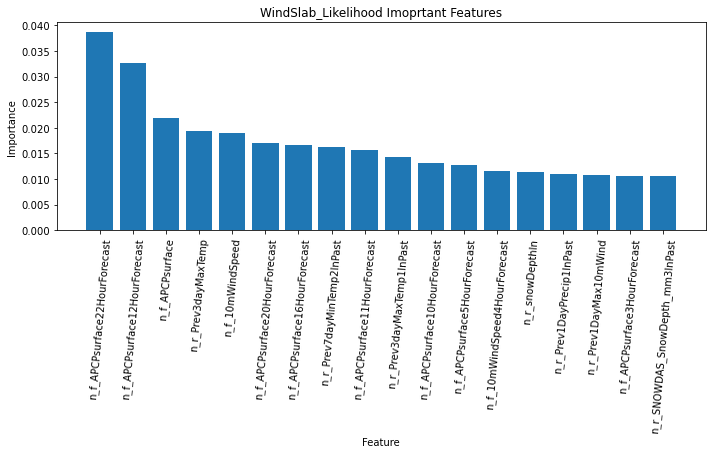

In [15]:
#Set a threshold for importance based on results above
importanceThreshold = .01

aboveThresVal = []
aboveThresFeat = []

#Find all of the features large than the threshold
for i,pair in enumerate(featureANDimportance):
    if pair[1] < importanceThreshold:
        break
    else:
        aboveThresVal.append(featureANDimportance[i][1])
        aboveThresFeat.append(featureANDimportance[i][0])

print("%d of %d total features above threshold"% (len(aboveThresFeat),len(featureLabels)))

#Plot the most important features and save graph
plt.figure(figsize =(10,6))
plt.ylabel('Importance');
plt.xticks(rotation=85);
plt.bar(aboveThresFeat,aboveThresVal);
plt.tight_layout()
plt.xlabel('Feature');
plt.title("%s Imoprtant Features"% target[2:])
plt.savefig(target[2:] +'_ImportantFeatures.png',facecolor = "white",dpi=300)

# Building a Decision Tree from Scratch, Save a cleaned CSV for use in GO

In [ ]:
#Save cleaned and balanced data as csv for use in go implementation of random forest
# goData = avyData.iloc[:,wForecastindex:numCols-2]
# goData.to_csv(r"Cleaned_Balanced_Data.csv", index = False);
# goData.head(5)

In [ ]:
# #Save cleaned and balanced data as csv for use in go implementation of random forest
goTrain,goTest = train_test_split(avyData.iloc[:,wForecastindex:numCols-2],test_size = .3,random_state = 99)
#goData = avyData.iloc[:,wForecastindex:numCols-2]
goTrain.to_csv(r"goTrain.csv", index = False);
goTest.to_csv(r"goTest.csv",index = False);
goTrain.head(10)